In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def split_dataset(ds, split_proportions, dataset_size=None):
    """
    Splits a dataset according to given proportions.

    Arguments:

    ds -- data set to be split
    split_proportions -- dictionary, desired proportions
    dataset_size -- size of dataset to be split
    """
    if not dataset_size:
        dataset_size = len(list(ds))
    split_dataset = {}
    for key, prop in split_proportions.items():
        samples = int(dataset_size * prop)
        split_dataset[key] = ds.take(samples)
        ds = ds.skip(samples)
    return split_dataset

In [3]:
def prepare_dataset(data):
    """
    Executes data preparation operations.

    Arguments:

    data -- dataset to be prepared
    """
    data = data.cache()
    data = data.shuffle(18000)
    data = data.batch(64)
    data = data.prefetch(100)
    return data

In [4]:
# Load Train data from our github repo
url_train = 'https://raw.githubusercontent.com/tjayada/iANNwTF_Project/main/data/cleaned%20data%20(1)/data_without_columns_train.csv'
url_train_with_locations = 'https://raw.githubusercontent.com/tjayada/iANNwTF_Project/main/data/cleaned%20data%20LSTM%20(1)/LSTM_data_without_columns_train.csv'
dataDF_train = pd.read_csv(url_train)

# Load Train label data from our github repo
url_train_labels = 'https://raw.githubusercontent.com/tjayada/iANNwTF_Project/main/data/cleaned%20data%20(1)/data_without_columns_train_labels.csv'
url_train_labels_with_locations = 'https://raw.githubusercontent.com/tjayada/iANNwTF_Project/main/data/cleaned%20data%20LSTM%20(1)/LSTM_data_without_columns_train_labels.csv'
dataDF_train_labels = pd.read_csv(url_train_labels)

# drop indexes 
dataDF_train = dataDF_train.drop("Unnamed: 0", axis = 1)
dataDF_train_labels = dataDF_train_labels.drop("Unnamed: 0", axis = 1)

dataDF_train = dataDF_train.to_numpy()
dataDF_train_labels = dataDF_train_labels.to_numpy()

# reshape input to be 3D [samples, timesteps, features]
dataDF_train = dataDF_train.reshape((dataDF_train.shape[0], 1, dataDF_train.shape[1]))

# combine training set and labels
ds = tf.data.Dataset.from_tensor_slices((dataDF_train, dataDF_train_labels))

#split dataset
datasets = split_dataset(ds, {'train': 0.7, 'valid': 0.1, 'test': 0.2})

# data preparation
datasets = {key: prepare_dataset(ds) for key, ds in datasets.items()}

In [5]:
class LSTM_Cell(tf.keras.layers.Layer):

    """
    Implementation of an LSTM cell.

    Parameters:

    self.units -- number of units
    """

    def __init__(self, units):
        """
        Constructor for an LSTM cell.

        Arguments:

        units -- number of units
        """
        super(LSTM_Cell, self).__init__()
        self.units = units
        # gates
        self.forget_gate = tf.keras.layers.Dense(units=units, activation=tf.nn.sigmoid, bias_initializer=tf.keras.initializers.Ones())
        self.input_gate = tf.keras.layers.Dense(units=units, activation=tf.nn.sigmoid)
        self.cell_state_candidates = tf.keras.layers.Dense(units=units, activation=tf.nn.tanh)
        self.output_gate = tf.keras.layers.Dense(units=units, activation=tf.nn.sigmoid)

    def call(self, x, states):
        """
        Call method for an LSTM cell. Updates and returns cell state and hidden state.

        Arguments:

        x -- input
        states -- old cell states
        """
        old_cell_state, old_hidden_state = states
        x_h = tf.concat([x, old_hidden_state], axis=1)
        # update cell state
        new_cell_state = tf.math.multiply(self.forget_gate(x_h), old_cell_state) +\
        tf.math.multiply(self.input_gate(x_h), self.cell_state_candidates(x_h))
        # update hidden state
        new_hidden_state = tf.math.multiply(self.output_gate(x_h), tf.nn.tanh(new_cell_state))

        return new_hidden_state, new_cell_state

In [6]:
class LSTM_Layer(tf.keras.layers.Layer):

    """
    Implementation of an LSTM layer.

    Parameters:

    units: number of units
    """
    def __init__(self, units):
        """
        Constructor for an LSTM layer.

        Arguments:

        units -- number of units
        """
        super(LSTM_Layer, self).__init__()
        self.lstm_1 = LSTM_Cell(units)

    @tf.function
    def call(self, x, states=None):
        """
        Calls the LSTM layer on given input with given cell states and returns output sequence.

        Arguments:

        x -- input
        states -- cell states
        """
        batch_size = tf.shape(x)[0]
        sequence_length = tf.shape(x)[1]
        # initialize states
        if not states:
            states = self.zero_states(batch_size)
        # initialize array for output sequence
        output_sequence = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
        # iterate through time steps in input sequence
        for seq_idx in tf.range(sequence_length):
            input = x[:, seq_idx]
            states = self.lstm_1(input, states)
            # write the new hidden state to the output_sequence
            output_sequence = output_sequence.write(seq_idx, states[0])
        output_sequence = tf.transpose(output_sequence.stack(), perm=[1,0,2])
        return output_sequence

    def zero_states(self, batch_size):
        """
        Generates and returns zero states by creating two zero tensors.

        Arguments:

        batch_size -- batch size of data set
        """
        return (tf.zeros((batch_size, self.lstm_1.units)), tf.zeros((batch_size, self.lstm_1.units)))

In [7]:
class MyModel(tf.keras.Model):

    """
    Implemtation of an LSTM model.

    Parameters:

    layer_list -- list of model's layers
    """
    def __init__(self, layer_list):
        """
        Constructor for an LSTM model.

        Arguments:

        layer_list -- list of model's layers
        """
        super(MyModel, self).__init__()
        self.layer_list = layer_list

    def call(self, x):
        """
        Calls the LSTM model on given inputs and returns outputs.

        Arguments:

        x -- input
        """
        input = x
        for layer in self.layer_list:
            input = layer(input)
        return input[:,-1,:]        

In [14]:
def training(input_model, datasets, loss_function, optimizer, epochs=100):
    """
    Training function. Takes a given model and executes the training loop. 
    Returns the model's loss.

    Arguments:

    input_model -- given model
    datasets -- data sets to feed into the model
    loss_function -- function to calculate the model's loss
    optimizer -- given optimizer
    epochs -- number of epochs to train
    """
    tf.keras.backend.clear_session()
    # Initialize list for tracking loss
    losses = {'train':[], 'valid':[], 'test':0}
        
    # Train-Dataset
    train_loss = test(input_model, datasets['train'], loss_function)

    losses['train'].append(train_loss)

    valid_loss = test(input_model, datasets['valid'], loss_function)

    losses['valid'].append(valid_loss)

    # Training for epochs
    for epoch in range(1, epochs+1):
        last_valid_loss = np.round(losses['valid'][-1], 3)
        print(f'Epoch {str(epoch)} starting with loss: {last_valid_loss}')
        epoch_loss_agg = []
        for input, target in datasets['train']:
            train_loss = train_step(
                input_model, input, target, loss_function, optimizer
            )
            epoch_loss_agg.append(train_loss)
        # track training loss and accuracy
        losses['train'].append(tf.reduce_mean(epoch_loss_agg))
        # track loss and accuracy for test-dataset
        valid_loss = test(input_model, datasets['valid'], loss_function)
        losses['valid'].append(valid_loss)
    test_loss = test(input_model, datasets['test'], loss_function)

    losses['test'] = test_loss  

    return losses

In [10]:
def train_step(model, input, target, loss_function, optimizer):
    """
    Implements a step in the training loop.
    Returns loss.

    Arguments:

    model -- given model
    input -- data input for the model to calculate a prediction
    target -- target to calculate loss
    optimizer -- given optimizer
    """
    with tf.GradientTape() as tape:
        # get a prediction from the model
        prediction = model(input)
        # calculate loss for this prediction
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    # apply gradients to the trainable variables using a optimizer
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return tf.sqrt(loss)

In [11]:
def test(model, test_data, loss_function):
    """
    Test function. Calculates and returns test loss.

    Arguments:

    model -- given model
    test_data -- testing data set
    loss_function -- given loss function 
    """
    # aggregator lists for tracking the loss and accuracy
    test_loss_agg = []
    # iterate over all input-target pairs in test_data
    for (input, target) in test_data:
        prediction = model(input)
        loss = loss_function(target, prediction)
        # add loss and accuracy to aggregators
        test_loss_agg.append(loss.numpy())
    # calculate mean loss and accuracy
    test_loss = tf.reduce_mean(test_loss_agg)
    return tf.sqrt(test_loss)

In [15]:
Model = MyModel(layer_list=[
    LSTM_Layer(200),
    tf.keras.layers.Dense(1, activation='linear')]
)
learning_rate = 0.01
# Initialize the loss-function
loss_func = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)
# Train our LSTM-Model using datasets, loss_func and the optimizer
losses = training(Model, datasets, loss_func, optimizer, epochs=10)

Epoch 1 starting with loss: 96.63099670410156
Epoch 2 starting with loss: 55.678001403808594
Epoch 3 starting with loss: 55.499000549316406
Epoch 4 starting with loss: 50.23899841308594
Epoch 5 starting with loss: 46.27000045776367
Epoch 6 starting with loss: 44.73899841308594
Epoch 7 starting with loss: 45.237998962402344
Epoch 8 starting with loss: 42.20899963378906
Epoch 9 starting with loss: 41.21900177001953
Epoch 10 starting with loss: 43.540000915527344


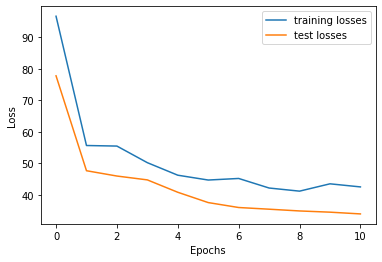

In [16]:
# Visualize accuracy and loss for training and test data.
import matplotlib.pyplot as plt
plt.figure()
line1, = plt.plot(losses['valid'])
line2, = plt.plot(losses['train'])
#line3 = plt.axhline(y=accuracies['test'], color='green', linestyle=":")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend((line1, line2),("training losses", "test losses"))
plt.show()